> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/dCruzCoding/NutriSynthCare)   
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta


In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibilidad
np.random.seed(42)

In [2]:
# Cargamos los csv y lo convertimos en dataframe
df_precov_full = pd.read_csv("dbfinal_precov.csv")

display(df_precov_full)

df_precov_full.info()

FileNotFoundError: [Errno 2] No such file or directory: 'dbfinal_precov.csv'

### OJO! 

Tras analizar la variable CCAA, me he dado cuenta que:

- Es exógena: No depende de las variables clínicas del paciente. Un paciente no tiene un nivel de colesterol determinado porque vive en Andalucía. Más bien, los hábitos, la genética y el sistema de salud de Andalucía influyen en la población, pero a nivel individual, es una característica dada.
- Es estocástica: Hay un componente de aleatoriedad. se ha modelado perfectamente: se asigno una comunidad a cada paciente basándote en una distribución de probabilidad (la del INE).

#### **Aplicando esta lógica a la base de datos Diabetes...**:
A la base de datos Diabetes le falta la columna Comunidad_Autonoma. En lugar de pedirle a un complejo modelo de imputación que "adivine" la comunidad basándose en IMC, Edad, HbA1c, etc. (lo cual es una relación que no existe en la realidad y fuerza al modelo a inventar patrones), puedes hacer exactamente lo que hiciste para Cardio: **asignar una comunidad a cada paciente del dataset Diabetes basándote en la misma distribución poblacional**.

In [ ]:
# df_diabetes es tu dataframe original de diabetes
# df_cardio es tu dataframe original de cardio (ya con CCAA)

# --- CCAA Comunidad Autónoma --- (Distribución según población INE 2019)
ccaas = [
    'Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria',
    'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'C. Valenciana',
    'Extremadura', 'Galicia', 'Madrid', 'Murcia', 'Navarra', 'País Vasco',
    'La Rioja', 'Ceuta', 'Melilla'
]

proporciones_ccaa = np.array([
    0.178, 0.028, 0.023, 0.025, 0.046, 0.012,
    0.052, 0.043, 0.164, 0.106,
    0.023, 0.058, 0.141, 0.032, 0.014, 0.047,
    0.007, 0.002, 0.002
])

# Normalizamos las proporciones para asegurar que sumen exactamente 1
proporciones_ccaa /= proporciones_ccaa.sum()

# Obtener los índices de las filas con NaN en 'Comunidad_Autonoma'
nan_indices = df_precov_full[df_precov_full['Comunidad_Autonoma'].isna()].index

# Añadimos la columna al DataFrame
df_precov_full.loc[nan_indices, 'Comunidad_Autonoma'] = np.random.choice(
    ccaas, size=len(nan_indices), p=proporciones_ccaa)

# Ahora ambos dataframes tienen la columna 'Comunidad_Autonoma'

In [ ]:
# Muestra las primeras filas para ver la estructura
print(df_precov_full.head())

# Información concisa: nombre de columnas, conteo de no nulos y tipo de dato (Dtype)
print(df_precov_full.info())

# Conteo de valores faltantes por columna
print(df_precov_full.isnull().sum())


### Vamos a convertir en numéricas lsa variables categóricas

In [ ]:
import pandas as pd
import numpy as np

# --- Creamos una copia del df para incluir solo var numericas ---
df_precov_num = df_precov_full.copy()

# --- Mapeo de variables con diccionarios definidos ---

# NOTA: Usaré un bloque try-except para cada una. Esto es una buena práctica.
# Si en el futuro ejecutas este código en un dataframe que ya ha sido codificado,
# no te dará un error, simplemente te avisará y continuará.

variables_a_mapear = {
    'Nivel_Estres': {'Bajo': 1, 'Moderado': 2, 'Alto': 3},
    'Actividad_Fisica': {'Sedentario': 1, 'Moderado': 2, 'Activo': 3, 'Muy activo': 4},
    'Riesgo_Cardiovascular': {'Bajo': 1, 'Moderado': 2, 'Alto': 3, 'Muy Alto': 4},
    'Consumo_Alcohol': {'No consume': 0, 'Bajo': 1, 'Moderado': 2, 'Alto': 3}, 
    'Sexo': {'Hombre': 1, 'Mujer': 0},
    'Diabetes': {'No': 0, 'Si': 1},
    'Tipo_Diabetes': {'No diabetes':0, 'Tipo 1':1, 'Tipo 2':2, 'Gestacional':3}
}

print("--- Codificando variables ordinales y binarias ---")
for col, mapa in variables_a_mapear.items():
    try:
        # Creamos una nueva columna con el sufijo '_encoded'
        nombre_col_encoded = f"{col}_encoded"
        df_precov_num[nombre_col_encoded] = df_precov_num[col].map(mapa)
        
        # Eliminar la columna original de texto
        df_precov_num = df_precov_num.drop(columns=[col])
        
        print(f"✅ Columna '{col}' codificada como '{nombre_col_encoded}'.")
    except Exception as e:
        print(f"⚠️ No se pudo codificar la columna '{col}'. ¿Quizás ya está en formato numérico o no existe? Error: {e}")

df_precov_num = pd.get_dummies(df_precov_num, columns=['Database'], prefix='source', drop_first=True)
# Esto te dará una columna 'source_Diabetes' (1 si es Diabetes, 0 si es Cardio)
# o 'source_Cardio', dependiendo de cuál elimines con drop_first. Ambas funcionan.

✅ Columna 'Actividad_Fisica' codificada como 'Actividad_Fisica_encoded'.
✅ Columna 'Riesgo_Cardiovascular' codificada como 'Riesgo_Cardiovascular_encoded'.
✅ Columna 'Consumo_Alcohol' codificada como 'Consumo_Alcohol_encoded'.
✅ Columna 'Sexo' codificada como 'Sexo_encoded'.
✅ Columna 'Diabetes' codificada como 'Diabetes_encoded'.
✅ Columna 'Tipo_Diabetes' codificada como 'Tipo_Diabetes_encoded'.


In [ ]:
# Debido al amplio número de valores en 'Comunidad_Autonoma', hay que usar otro método -> One-Hot Encoding

num_comunidades = df_precov_num['Comunidad_Autonoma'].nunique()
print(f"Número de valores diferentes en 'Comunidad_Autonoma': {num_comunidades}")

print("\n--- Codificando 'Comunidad_Autonoma' con One-Hot Encoding ---")

# Usamos pd.get_dummies
df_precov_num = pd.get_dummies(
    df_precov_num, 
    columns=['Comunidad_Autonoma'], 
    prefix='CCAA', # El prefijo para los nombres de las nuevas columnas
    dtype=int, # Asegura que las nuevas columnas sean 0/1 enteros
    drop_first=True
)

print("✅ 'Comunidad_Autonoma' codificada. Se han añadido nuevas columnas 'CCAA_...'")
print("Nuevas columnas creadas:", [col for col in df_precov_num.columns if col.startswith('CCAA_')])

In [ ]:
# --- IDENTIFICACIÓN AUTOMÁTICA DE COLUMNAS A REDONDEAR ---

# Lista de columnas que eran originalmente categóricas y ahora son numéricas
# Estas son las que necesitaremos redondear después de la imputación.

# 1. Columnas que terminan en '_encoded'
encoded_cols = [col for col in df_precov_num.columns if col.endswith('_encoded')]

# 2. Columnas de One-Hot Encoding para Comunidad Autónoma (empiezan con 'CCAA_')
ccaa_cols = [col for col in df_precov_num.columns if col.startswith('CCAA_')]

# 3. La columna de origen de la base de datos (si la creaste con get_dummies)
#    Asumo que se llama algo como 'source_Diabetes' o 'source_Cardio'.
#    Si no la creaste con get_dummies, añádela manualmente.
source_cols = [col for col in df_precov_num.columns if col.startswith('source_')]

# Combinamos todas las listas
categorical_imputed_cols = encoded_cols + ccaa_cols + source_cols

print(f"Se han identificado {len(categorical_imputed_cols)} columnas categóricas codificadas para el post-procesamiento.")
print("Primeras 10 columnas identificadas:", categorical_imputed_cols[:10])

# IMPORTANTE: Asegúrate de que no estás incluyendo aquí variables numéricas originales.
# Por ejemplo, si una variable se llamaba 'Presion_encoded', este método la cogería.
# Revisa la lista y si ves alguna que no debería estar, elimínala manualmente.

In [ ]:
df_precov_num

#### ExtraTreesRegressor que es más rapidico.
Distribuciones: not bad
--- Resumen de la Estabilidad de las Correlaciones ---
- ✅ Aceptable: Cambio insignificante.                       82
- Error                                                     41
- 🟡 Revisar: Cambio menor, probablemente aceptable.         30
- ⚠️ Alerta: Cambio notable. La relación se ha alterado.    25
- 🚨 CRÍTICO: La relación ha cambiado drásticamente.         12
- Name: count, dtype: int64


#### Pasamos a BayesianRidge.

- Es un modelo lineal. Asumirá que las relaciones entre las variables son, en su mayoría, lineales. Esto es una suposición fuerte, pero es exactamente lo que el test de correlación de Pearson (el que usa .corr()) mide. Por lo tanto, es mucho más probable que preserve estas correlaciones.
- Es robusto. Tiene regularización incorporada, lo que lo hace menos sensible a outliers y al ruido en los datos.
- Es rápido. Será notablemente más rápido que RandomForest.

Distribuciones: horrorosas
--- Resumen de la Estabilidad de las Correlaciones ---
- ✅ Aceptable: Cambio insignificante.                       73
- 🚨 CRÍTICO: La relación ha cambiado drásticamente.         48
- Error                                                     41
- ⚠️ Alerta: Cambio notable. La relación se ha alterado.    23
- 🟡 Revisar: Cambio menor, probablemente aceptable.          5
- Name: count, dtype: int64

El hecho de que BayesianRidge empeorara tanto las distribuciones como las correlaciones es una prueba contundente de que las relaciones en tus datos NO son lineales, y que el modelo simple es incapaz de capturar la verdadera estructura, llevando a imputaciones pobres.

Esto nos dice que el camino a seguir es, efectivamente, volver a los modelos de árboles (ExtraTreesRegressor o similar), pero con un control mucho más fino. Tu idea de usar early stopping y hacerlo más potente es exactamente la correcta.


#### HistGradientBoostingRegressor
- Potencia: Es un modelo de gradient boosting, a menudo más potente y preciso que Random Forest/Extra Trees. Es la implementación de Scikit-learn inspirada en LightGBM.
- Velocidad: Es muchísimo más rápido que RandomForestRegressor para datasets grandes, lo que nos permite usar más iteraciones o árboles sin que el tiempo se dispare.
- Control de Sobreajuste: Tiene parámetros de regularización muy efectivos (max_leaf_nodes, l2_regularization) que nos permitirán controlar la complejidad del modelo, que es justo lo que necesitamos.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor
import time

# --- 1. CONFIGURAR EL ESTIMADOR DE ALTA GAMA ---
# Este estimador será potente pero con restricciones para evitar el sobreajuste.

hgb_estimator = HistGradientBoostingRegressor(
    max_iter=100,              # Número de árboles en el modelo de boosting. 100 es un buen default.
    max_leaf_nodes=31,         # Controla la complejidad de cada árbol. Default es 31. Es el principal regularizador.
    learning_rate=0.1,         # Tasa de aprendizaje. Default es 0.1.
    l2_regularization=1.0,     # Penalización L2 para evitar que los pesos de las hojas se disparen. Añade estabilidad.
    random_state=42,
    # No necesitamos n_iter_no_change (early stopping) aquí, ya que el IterativeImputer
    # lo controla con su propio ciclo de max_iter.
)

# --- 2. CONFIGURAR EL IMPUTADOR ITERATIVO ---
# Le daremos más "vueltas" (max_iter) para que las imputaciones converjan mejor,
# ya que ahora nuestro estimador es mucho más rápido.

imputer_pro = IterativeImputer(
    estimator=hgb_estimator,
    max_iter=15,               # Aumentamos el número de ciclos de imputación a 15.
    initial_strategy='mean',   # Empezar con la media es a menudo más estable.
    tol=1e-3,                  # Tolerancia para la convergencia. El default.
    random_state=42,
    verbose=2                  # Para ver el progreso.
)


# --- 3. EJECUTAR LA IMPUTACIÓN ---
print("🚀 Iniciando imputación de alta gama con HistGradientBoostingRegressor. Será rápido...")
start_time = time.time()

# Usamos el mismo df_precov_num que antes
df_imputed_pro_array = imputer_pro.fit_transform(df_precov_num)

end_time = time.time()
print(f"\n✅ Imputación PRO finalizada en {(end_time - start_time) / 60:.2f} minutos.")


# --- 4. CREAR EL NUEVO DATAFRAME Y POST-PROCESAR ---
df_imputed = pd.DataFrame(df_imputed_pro_array, columns=df_precov_num.columns)

print("\n🔧 Realizando post-procesamiento en el nuevo DataFrame 'df_imputed_pro'...")
# Reutilizamos la lista de columnas categóricas que ya tenías
# categorical_imputed_cols = [...]
for col in categorical_imputed_cols:
    if col in df_imputed.columns:
        df_imputed[col] = df_imputed[col].round().astype(int)
print("✅ Post-procesamiento finalizado.")

In [ ]:
# --- VERIFICACIÓN FINAL ---
print("\nVerificación de los resultados:")

# 1. Comprueba si quedan valores nulos
print(f"Total de valores nulos en el df_imputed final: {df_imputed.isnull().sum().sum()}")

# 2. Revisa los valores de una de las columnas post-procesadas
#    Por ejemplo, la de Sexo. Debería contener solo 0s y 1s.
if 'Sexo_encoded' in df_imputed.columns:
    print(f"Valores únicos en 'Sexo_encoded' después de la corrección: {df_imputed['Sexo_encoded'].unique()}")

# 3. Revisa los valores de una variable numérica que fue imputada
#    Por ejemplo, 'Ingresos_Anuales'. Debería ser de tipo float y no tener nulos.
if 'Ingresos_Anuales' in df_imputed.columns:
    print(f"Tipo de dato de 'Ingresos_Anuales': {df_imputed['Ingresos_Anuales'].dtype}")
    print(f"Valores nulos en 'Ingresos_Anuales': {df_imputed['Ingresos_Anuales'].isnull().sum()}")

### VALIDACIÓN DE LOS DATOS IMPUTADOS

#### Metodo 1: "Sanity Check" (Plausibilidad)
Comparar distribuciones antes y después, para ver que tal la estadistica descriptiva.

#### Método 2: Validacion visual
Comparamos la distribución de los datos observados con la distribución de los datos completos (observados + imputados). Si la imputación es buena, las dos distribuciones deberían ser muy similares.

#### Metodo 3: Correlaciones

In [ ]:
# Lista de columnas a excluir del .describe() para mayor claridad
cols_to_exclude_describe = [col for col in df_imputed.columns if col.startswith('CCAA_')]

# .describe() en el dataframe imputado sin las CCAA
print("\n--- Descripción del DataFrame Imputado (sin CCAA) ---")
print(df_imputed.drop(columns=cols_to_exclude_describe).describe())

# Compara el .describe() del dataframe original (sin imputar) con el imputado
print("--- Descripción del DataFrame Original (df_precov_num) ---")
print(df_precov_num.drop(columns=cols_to_exclude_describe).describe())

       Año_Registro          Edad  Ingresos_Anuales           IMC  \
count  16000.000000  16000.000000      16000.000000  16000.000000   
mean    2014.546625     52.947187      30339.508196     30.276114   
std        2.866961     11.061811      14713.371064      5.770551   
min     2010.000000     21.000000       4333.670000     15.000000   
25%     2012.000000     46.000000      17748.150000     25.735340   
50%     2015.000000     54.000000      27084.020000     30.600000   
75%     2017.000000     61.000000      43670.140005     34.500000   
max     2019.000000     87.000000      76878.410000     47.400000   

       Colesterol_Total  Trigliceridos           PAS           PAD  \
count      16000.000000   16000.000000  16000.000000  16000.000000   
mean         219.977796     192.904655    149.696194     91.428994   
std           17.507429      56.551505     16.915139      9.492172   
min          143.906359      90.000000     98.200000     63.500000   
25%          208.490000     

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identifica las columnas que tenían NaNs en el dataframe original
cols_con_nans = df_precov_num.columns[df_precov_num.isnull().any()].tolist()

# 2. Filtra esta lista para excluir las columnas de CCAA y las codificadas que no son numéricas continuas
#    Esto nos deja con las variables principales que queremos validar.
numeric_cols_to_plot = [
    col for col in cols_con_nans 
    if not col.startswith('CCAA_') and not col.endswith('_encoded')
]

print(f"--- VALIDACIÓN VISUAL DE DISTRIBUCIONES ---")
print(f"Columnas a validar: {numeric_cols_to_plot}\n")

# 3. Crea un gráfico de densidad para cada una
for col in numeric_cols_to_plot:
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(df_precov_num[col].dropna(), label='Original (Observado)', color='blue', linewidth=2, fill=True, alpha=0.1)
    sns.kdeplot(df_imputed[col], label='Completo (con Imputados)', color='orange', linestyle='--', linewidth=2)
    
    plt.title(f"Distribución de '{col}': Original vs. Imputado", fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Densidad", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
# 1. Crea una lista con las columnas de CCAA para excluirlas
ccaa_cols = [col for col in df_precov_num.columns if col.startswith('CCAA_')]

# 2. Crea los DataFrames para el análisis de correlación SIN las columnas de CCAA
df_corr_original = df_precov_num.drop(columns=ccaa_cols)
df_corr_imputed = df_imputed.drop(columns=ccaa_cols)

# 3. Calcula las matrices de correlación en los dataframes filtrados
corr_original = df_corr_original.corr()
corr_imputed = df_corr_imputed.corr()

print("\n--- VALIDACIÓN DE CORRELACIONES (excluyendo CCAA) ---")

# 4. Visualiza ambas matrices con heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(corr_original, ax=ax1, cmap='viridis', vmin=-1, vmax=1)
ax1.set_title('Correlaciones en DataFrame Original', fontsize=16)

sns.heatmap(corr_imputed, ax=ax2, cmap='viridis', vmin=-1, vmax=1)
ax2.set_title('Correlaciones en DataFrame Imputado', fontsize=16)

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- 1. PREPARACIÓN: Excluir columnas CCAA para el análisis ---
# Asegúrate de que df_precov_num y df_imputed están disponibles

ccaa_cols = [col for col in df_precov_num.columns if col.startswith('CCAA_')]

df_corr_original = df_precov_num.drop(columns=ccaa_cols)
df_corr_imputed = df_imputed.drop(columns=ccaa_cols)


# --- 2. CÁLCULO DE CORRELACIONES ---

corr_pre = df_corr_original.corr().unstack()
corr_post = df_corr_imputed.corr().unstack()


# --- 3. CREACIÓN DEL DATAFRAME DE COMPARACIÓN ---

# Combina las dos series de correlaciones en un solo DataFrame
corr_comparison_df = pd.DataFrame({
    'corr_pre_imputacion': corr_pre,
    'corr_post_imputacion': corr_post
}).reset_index()

corr_comparison_df.rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2'}, inplace=True)


# --- 4. LIMPIEZA Y CÁLCULOS ADICIONALES ---

# a. Eliminar correlaciones de una variable consigo misma (que siempre son 1.0)
corr_comparison_df = corr_comparison_df[corr_comparison_df['Variable_1'] != corr_comparison_df['Variable_2']]

# b. Eliminar pares duplicados (ej. (A,B) es lo mismo que (B,A))
#    Creamos una clave única para cada par ordenando los nombres de las variables
corr_comparison_df['pair_key'] = corr_comparison_df.apply(
    lambda row: tuple(sorted((row['Variable_1'], row['Variable_2']))), 
    axis=1
)
corr_comparison_df = corr_comparison_df.drop_duplicates(subset=['pair_key']).drop(columns=['pair_key'])

# c. Calcular la diferencia absoluta en la correlación
corr_comparison_df['diferencia'] = (corr_comparison_df['corr_post_imputacion'] - corr_comparison_df['corr_pre_imputacion']).abs()


# --- 5. INTERPRETACIÓN AUTOMÁTICA CON EMOJIS ---

# Definimos los umbrales para la interpretación
conditions = [
    corr_comparison_df['diferencia'] < 0.05,
    (corr_comparison_df['diferencia'] >= 0.05) & (corr_comparison_df['diferencia'] < 0.1),
    (corr_comparison_df['diferencia'] >= 0.1) & (corr_comparison_df['diferencia'] < 0.2),
    corr_comparison_df['diferencia'] >= 0.2
]

# Definimos los resultados para cada condición (emoji + texto)
choices = [
    '✅ Aceptable: Cambio insignificante.',
    '🟡 Revisar: Cambio menor, probablemente aceptable.',
    '⚠️ Alerta: Cambio notable. La relación se ha alterado.',
    '🚨 CRÍTICO: La relación ha cambiado drásticamente.'
]

corr_comparison_df['interpretacion'] = np.select(conditions, choices, default='Error')


# --- 6. PRESENTACIÓN DE RESULTADOS ---

# Ordenamos el DataFrame para ver las mayores diferencias primero
corr_comparison_df = corr_comparison_df.sort_values(by='diferencia', ascending=False).reset_index(drop=True)

# Mostramos un resumen y los 20 pares con los mayores cambios
print("📊 DataFrame de Comparación de Correlaciones (Pre vs. Post Imputación)")
print("="*70)
print("A continuación se muestran los pares de variables cuya correlación más ha cambiado")
print("después del proceso de imputación. Presta especial atención a los niveles 'Alerta' y 'CRÍTICO'.\n")

display(corr_comparison_df.head(12))

# También podemos ver un resumen de las interpretaciones
print("\n--- Resumen de la Estabilidad de las Correlaciones ---")
print(corr_comparison_df['interpretacion'].value_counts())

print("\n\n OJO! Error se debe a que en preImputacion las columnas exclusivas tenian valores NaN así que da error en la corr. Así que es normal, no pasa nada.")

In [ ]:
# Filtra para obtener solo las filas problemáticas
problematic_rows = corr_comparison_df[
    corr_comparison_df['interpretacion'].isin(['⚠️ Alerta: Cambio notable. La relación se ha alterado.', 
                                             '🚨 CRÍTICO: La relación ha cambiado drásticamente.'])
]

# Contamos cuántas veces aparece cada variable en la lista de problemáticas
offenders_count = pd.concat([problematic_rows['Variable_1'], problematic_rows['Variable_2']]).value_counts()

print("--- Variables que Aparecen con más Frecuencia en Relaciones Alteradas ---")
print(offenders_count.head(10))

## 📊 Análisis de Correlaciones Post-Imputación: ¿Por qué el enfoque global falla?

Ya hemos comentado que el Error se debe a un planteamiento de las correlaciones, pero y el critico? Y la alerta? Por qué tantos valores?                                                  
- ⚠️ Alerta: Cambio notable. La relación se ha alterado.    34
- 🚨 CRÍTICO: La relación ha cambiado drásticamente.         27


### ❌ El Problema del Análisis Global  
Al comparar correlaciones **antes vs después** de imputar en todo el dataset:  
- **Se mezclan subgrupos distintos**: Las correlaciones pre-imputación se calculan sobre pacientes con datos disponibles (grupos parciales).  
- **Post-imputación se usa el dataset completo**: Esto genera comparaciones injustas entre relaciones calculadas en cohortes diferentes.  

#### 🧩 Ejemplo Ilustrativo  
```python
# Dataset original (antes de imputar)
Paciente  IMC  Ingresos_Anuales  HbA1c     Origen
1        25    30000            NaN      Cardio
2        28    40000            NaN      Cardio
3        35    NaN              7.5      Diabetes
4        40    NaN              8.5      Diabetes
```

- **`corr(IMC, HbA1c)` pre-imputación**: Solo usa pacientes 3 y 4 (Diabetes).  
- **`corr(IMC, HbA1c)` post-imputación**: Usa todos los pacientes (1-4).  
→ **¡Comparas peras con manzanas!**  

---

### ✅ Solución: Enfoque por Cohortes  
#### 🔍 Dos Preguntas Clave  
1. **¿Se preservaron las relaciones originales?**  
   - Ej: En pacientes *Diabetes*, comparar `corr(IMC, HbA1c)` antes/después.  
   - **Si cambia**: ¡Alarmante! La imputación alteró patrones existentes.  

2. **¿Son plausibles las nuevas relaciones?**  
   - Ej: En pacientes *Diabetes*, evaluar `corr(Ingresos_Anuales, HbA1c)` post-imputación.  
   - **Criterio**: Coherencia médica (ej: ¿Ingresos bajos ↔ HbA1c alto? ✔️; ¿Correlación = 0.99? ❌).  

#### 📌 Beneficios  
| **Enfoque Global** | **Enfoque por Cohortes** |
|---------------------|--------------------------|
| Compara grupos distintos | Compara el mismo grupo |
| Sensible a artefactos matemáticos | Evalúa preservación y coherencia |
| Difícil interpretación | Resultados accionables |

---

### 💡 Conclusión  
**El análisis global es engañoso** porque:  
- Las correlaciones pre-imputación son fragmentadas (NaN excluyen pacientes).  
- Post-imputación introduce datos sintéticos que deben validarse **en contexto**.  

**Usa cohortes para:**  
✔️ Verificar que lo existente no se corrompió.  
✔️ Validar que lo imputado es clínicamente razonable.  

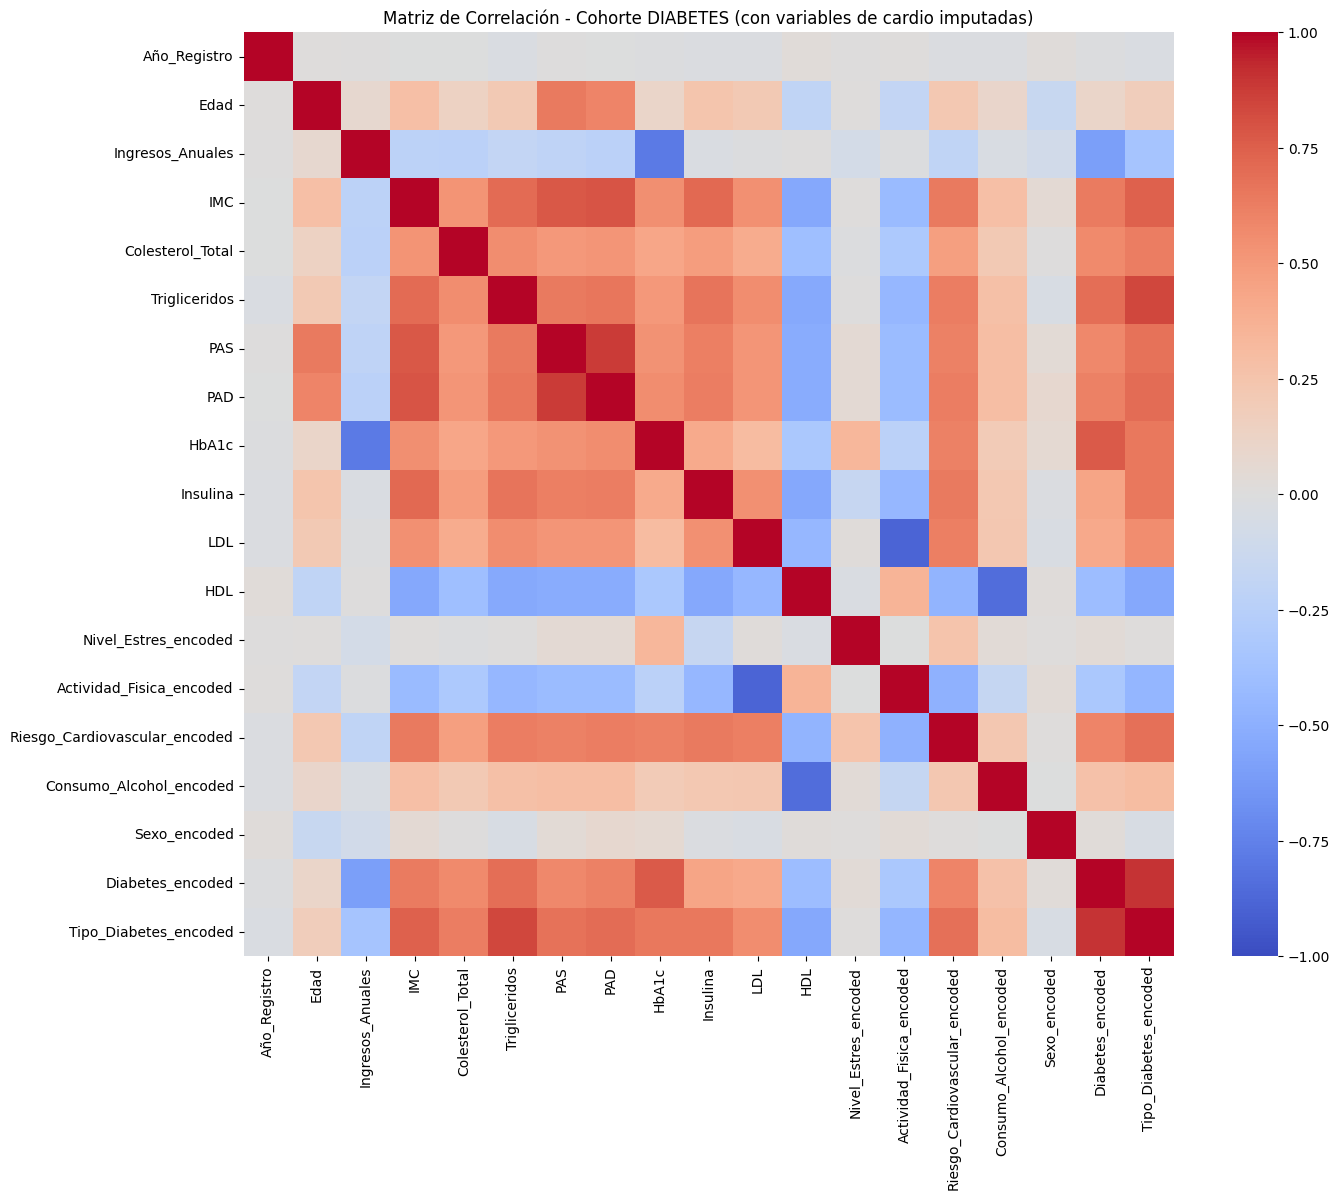

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- PASO 1: DIVIDIR EL DATAFRAME IMPUTADO EN SUS GRUPOS ORIGINALES ---
# Usamos la columna 'source_Diabetes' que creaste (o como la hayas llamado).
# Asumo que 'df_imputed' es tu dataframe final, ya imputado y post-procesado (con redondeo).
# Asumo que 'source_Diabetes' == 0 para el grupo Cardio, y 1 para el grupo Diabetes.
# ¡Verifica esto y ajústalo si es necesario!

print("--- Separando el DataFrame final en sus cohortes originales ---")

# Cohorte original de Riesgo Cardiovascular
df_cardio_final = df_imputed[df_imputed['source_Diabetes'] == 0].copy()
# Cohorte original de Diabetes
df_diabetes_final = df_imputed[df_imputed['source_Diabetes'] == 1].copy()

print(f"Tamaño de la cohorte Cardio final: {df_cardio_final.shape}")
print(f"Tamaño de la cohorte Diabetes final: {df_diabetes_final.shape}")


# --- PASO 2: CÁLCULO DE LAS MATRICES DE CORRELACIÓN PARA CADA COHORTE ---

# Excluimos las columnas de CCAA y la propia columna 'source' para no ensuciar el análisis
ccaa_cols = [col for col in df_imputed.columns if col.startswith('CCAA_')]
cols_to_drop = ccaa_cols + ['source_Diabetes']

corr_cardio = df_cardio_final.drop(columns=cols_to_drop).corr()
corr_diabetes = df_diabetes_final.drop(columns=cols_to_drop).corr()

print("\n✅ Matrices de correlación para cada cohorte calculadas.")


# --- PASO 3: ANÁLISIS DIRIGIDO DE CORRELACIONES CLAVE ---

print("\n\n--- 🔬 ANÁLISIS DE LA COHORTE CARDIO (Variables de Diabetes Imputadas) ---")
print("="*70)

# Pregunta A: ¿Se mantienen las relaciones originales? (Ej. Ingresos vs. Estrés)
print("1. Correlación original-original (preservación):")
try:
    corr_val = corr_cardio.loc['Ingresos_Anuales', 'Nivel_Estres_encoded']
    print(f"   - Correlación (Ingresos_Anuales, Nivel_Estres): {corr_val:.3f}")
except KeyError:
    print("   - No se encontraron las columnas especificadas.")

# Pregunta B: ¿Son lógicas las nuevas relaciones imputadas? (Ej. HbA1c vs. IMC/Riesgo)
print("\n2. Correlación original-imputada (coherencia):")
try:
    corr_val_1 = corr_cardio.loc['HbA1c', 'IMC']
    corr_val_2 = corr_cardio.loc['HbA1c', 'Riesgo_Cardiovascular_encoded']
    print(f"   - Correlación (HbA1c imputada, IMC): {corr_val_1:.3f} (Esperaríamos positiva)")
    print(f"   - Correlación (HbA1c imputada, Riesgo_Cardiovascular): {corr_val_2:.3f} (Esperaríamos fuertemente positiva)")
except KeyError:
    print("   - No se encontraron las columnas especificadas.")


print("\n\n--- 🔬 ANÁLISIS DE LA COHORTE DIABETES (Variables de Cardio Imputadas) ---")
print("="*70)

# Pregunta A: ¿Se mantienen las relaciones originales? (Ej. HbA1c vs. Insulina)
print("1. Correlación original-original (preservación):")
try:
    corr_val = corr_diabetes.loc['HbA1c', 'Insulina']
    print(f"   - Correlación (HbA1c, Insulina): {corr_val:.3f}")
except KeyError:
    print("   - No se encontraron las columnas especificadas.")
    
# Pregunta B: ¿Son lógicas las nuevas relaciones imputadas? (Ej. Riesgo Cardio vs. HbA1c/LDL)
print("\n2. Correlación original-imputada (coherencia):")
try:
    corr_val_1 = corr_diabetes.loc['Riesgo_Cardiovascular_encoded', 'HbA1c']
    corr_val_2 = corr_diabetes.loc['Riesgo_Cardiovascular_encoded', 'LDL']
    print(f"   - Correlación (Riesgo_Cardiovascular imputado, HbA1c): {corr_val_1:.3f} (Esperaríamos fuertemente positiva)")
    print(f"   - Correlación (Riesgo_Cardiovascular imputado, LDL): {corr_val_2:.3f} (Esperaríamos positiva)")
except KeyError:
    print("   - No se encontraron las columnas especificadas.")

    
# --- PASO 4: VISUALIZACIÓN (Opcional, pero recomendado) ---
# Los heatmaps pueden ser muy grandes, pero dan una idea visual de la estructura.

plt.figure(figsize=(15, 12))
sns.heatmap(corr_cardio, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Cohorte CARDIO (con variables de diabetes imputadas)')
plt.show()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_diabetes, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Cohorte DIABETES (con variables de cardio imputadas)')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- FUNCIÓN REUTILIZABLE PARA CREAR LA TABLA DE COMPARACIÓN ---
# La encapsulamos en una función para no repetir código.

def generar_tabla_comparacion_correlaciones(df_original, df_imputado, nombre_cohorte):
    """
    Genera una tabla de comparación de correlaciones para una cohorte específica.
    """
    # Excluir columnas CCAA y de origen
    ccaa_cols = [col for col in df_original.columns if col.startswith('CCAA_')]
    cols_to_drop = ccaa_cols + ['source_Diabetes'] if 'source_Diabetes' in df_original.columns else ccaa_cols

    # Calcular correlaciones. dropna() es crucial en el df_original para ser explícitos.
    corr_pre = df_original.drop(columns=cols_to_drop).corr().unstack()
    corr_post = df_imputado.drop(columns=cols_to_drop).corr().unstack()

    # Crear el DataFrame de comparación
    corr_df = pd.DataFrame({
        'corr_pre_imputacion': corr_pre,
        'corr_post_imputacion': corr_post
    }).reset_index().rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2'})

    # Limpieza
    corr_df = corr_df[corr_df['Variable_1'] != corr_df['Variable_2']]
    corr_df['pair_key'] = corr_df.apply(lambda row: tuple(sorted((row['Variable_1'], row['Variable_2']))), axis=1)
    corr_df = corr_df.drop_duplicates(subset=['pair_key']).drop(columns=['pair_key'])
    
    # Filtrar pares donde la correlación pre-imputación no se pudo calcular (era NaN)
    corr_df.dropna(subset=['corr_pre_imputacion'], inplace=True)
    
    # Calcular diferencia e interpretación
    corr_df['diferencia'] = (corr_df['corr_post_imputacion'] - corr_df['corr_pre_imputacion']).abs()
    
    conditions = [
        corr_df['diferencia'] < 0.05,
        (corr_df['diferencia'] >= 0.05) & (corr_df['diferencia'] < 0.1),
        (corr_df['diferencia'] >= 0.1) & (corr_df['diferencia'] < 0.2),
        corr_df['diferencia'] >= 0.2
    ]
    choices = [
        '✅ Aceptable: Cambio insignificante.',
        '🟡 Revisar: Cambio menor, probablemente aceptable.',
        '⚠️ Alerta: Cambio notable. La relación se ha alterado.',
        '🚨 CRÍTICO: La relación ha cambiado drásticamente.'
    ]
    corr_df['interpretacion'] = np.select(conditions, choices, default='Error')

    # Presentación de resultados
    corr_df = corr_df.sort_values(by='diferencia', ascending=False).reset_index(drop=True)

    print(f"\n\n📊 TABLA DE ESTABILIDAD DE CORRELACIONES - COHORTE: {nombre_cohorte.upper()}")
    print("="*80)
    print("Esto muestra cómo ha cambiado la correlación DENTRO de esta cohorte específica.")
    
    # Usar display() para obtener el formato HTML bonito en Jupyter
    display(corr_df)

    print(f"\n--- Resumen de Estabilidad para la Cohorte {nombre_cohorte} ---")
    print(corr_df['interpretacion'].value_counts())


# --- EJECUCIÓN DEL ANÁLISIS ---

# Necesitamos los dataframes originales de cada cohorte ANTES de la imputación
# Asumo que tu dataframe pre-imputación se llama 'df_precov_num'
df_cardio_original = df_precov_num[df_precov_num['source_Diabetes'] == 0].copy()
df_diabetes_original = df_precov_num[df_precov_num['source_Diabetes'] == 1].copy()

# Y los dataframes ya imputados de cada cohorte
# df_cardio_final y df_diabetes_final ya los creamos en el paso anterior

# Generar la tabla para la cohorte de DIABETES
# Aquí comparamos las relaciones del df de diabetes original vs. las mismas 8000 filas después de imputarles
# las variables de cardio. El foco está en ver si se preservaron las relaciones originales de diabetes.
generar_tabla_comparacion_correlaciones(df_diabetes_original, df_diabetes_final, "Diabetes")

# Generar la tabla para la cohorte de CARDIO
generar_tabla_comparacion_correlaciones(df_cardio_original, df_cardio_final, "Cardio")

In [ ]:
# Creo un DataFrame temporal con los datos pre-redondeo
df_antes_redondeo = pd.DataFrame(df_imputed_pro_array, columns=df_precov_num.columns)

print("--- 🔍 ANÁLISIS DE SESGO POR REDONDEO ---")
print("="*70)
print("Comparando la media de las variables antes y después del redondeo:")

for col in categorical_imputed_cols:
    if col in df_imputed.columns:
        mean_antes = df_antes_redondeo[col].mean()
        mean_despues = df_imputed[col].mean()
        diferencia_pct = 100 * (mean_despues - mean_antes) / mean_antes if mean_antes != 0 else 0
        
        print(f"- Columna '{col}':")
        print(f"  - Media Antes: {mean_antes:.4f}")
        print(f"  - Media Después: {mean_despues:.4f}")
        print(f"  - Cambio porcentual: {diferencia_pct:.2f}%")
        if diferencia_pct < 2: 
            print("✅ Cambio insignificante\n")

print("\nSi los cambios porcentuales son pequeños (ej. < 1-2%), el efecto del redondeo es probablemente insignificante.")

- Columna 'CCAA_C. Valenciana':
  - Media Antes: 0.1084
  - Media Después: 0.1084
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Canarias':
  - Media Antes: 0.0457
  - Media Después: 0.0457
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Cantabria':
  - Media Antes: 0.0122
  - Media Después: 0.0122
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Castilla y León':
  - Media Antes: 0.0541
  - Media Después: 0.0541
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Castilla-La Mancha':
  - Media Antes: 0.0413
  - Media Después: 0.0413
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Cataluña':
  - Media Antes: 0.1611
  - Media Después: 0.1611
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Ceuta':
  - Media Antes: 0.0024
  - Media Después: 0.0024
  - Cambio porcentual: 0.00%
✅ Cambio insignificante

- Columna 'CCAA_Extremadura':
  - Media Antes: 0.0236
  - Media

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- PASO 1: DEFINIR LAS VARIABLES ORIGINALES DE CADA GRUPO ---
# (Excluyendo las que son comunes a ambos como IMC, Edad, etc.)

# Variables que solo existían en el dataset de CARDIO
vars_cardio_exclusivas = [
    'Riesgo_Cardiovascular_encoded', 'Actividad_Fisica_encoded',
    'Ingresos_Anuales', 'Nivel_Estres_encoded', 'Consumo_Alcohol_encoded'
]

# Variables que solo existían en el dataset de DIABETES
vars_diabetes_exclusivas = [
    'Tipo_Diabetes_encoded', 'HbA1c', 'Insulina', 'LDL', 'HDL'
]

# Variables que eran comunes a AMBOS datasets
vars_comunes = [
    'Año_Registro', 'Edad', 'Sexo_encoded', 'IMC', 'Diabetes_encoded',
    'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD'
]

# --- PASO 2: EXTRAER LAS MATRICES DE CORRELACIÓN DE COHERENCIA ---
# Usaremos las matrices `corr_cardio` y `corr_diabetes` que ya calculamos.

print("--- 🧠 MATRIZ DE COHERENCIA: COHORTE CARDIO ---")
print("Correlación entre las variables ORIGINALES de Cardio (filas) y las IMPUTADAS de Diabetes (columnas)")

# Seleccionamos las filas y columnas de interés de la matriz de correlación de la cohorte Cardio
# Nos aseguramos de que las columnas existan antes de intentar seleccionarlas
valid_cardio_vars = [v for v in vars_cardio_exclusivas + vars_comunes if v in corr_cardio.index]
valid_diabetes_vars = [v for v in vars_diabetes_exclusivas if v in corr_cardio.columns]

coherencia_cardio = corr_cardio.loc[valid_cardio_vars, valid_diabetes_vars]

# Usamos un heatmap para visualizarlo. Es la mejor forma.
plt.figure(figsize=(10, 12))
sns.heatmap(
    coherencia_cardio,
    annot=True,          # Mostrar los valores numéricos
    cmap='coolwarm',     # Esquema de color azul-rojo
    vmin=-1, vmax=1,     # Anclar la escala de color de -1 a 1
    fmt=".2f"            # Formatear los números a 2 decimales
)
plt.title('Matriz de Coherencia: Cohorte CARDIO\n(Originales de Cardio vs. Imputadas de Diabetes)', fontsize=14)
plt.show()


print("\n\n--- 🧠 MATRIZ DE COHERENCIA: COHORTE DIABETES ---")
print("Correlación entre las variables ORIGINALES de Diabetes (filas) y las IMPUTADAS de Cardio (columnas)")

# Hacemos lo mismo para la cohorte de Diabetes
valid_diabetes_vars = [v for v in vars_diabetes_exclusivas + vars_comunes if v in corr_diabetes.index]
valid_cardio_vars = [v for v in vars_cardio_exclusivas if v in corr_diabetes.columns]

coherencia_diabetes = corr_diabetes.loc[valid_diabetes_vars, valid_cardio_vars]

# Visualizamos con un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    coherencia_diabetes,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".2f"
)
plt.title('Matriz de Coherencia: Cohorte DIABETES\n(Originales de Diabetes vs. Imputadas de Cardio)', fontsize=14)
plt.show()




In [ ]:
import pandas as pd

# --- PASO 1: DEFINIR LAS PRUEBAS DE COHERENCIA ---
# Cada prueba es un diccionario con:
# - 'cohorte': En qué grupo de pacientes se realiza la prueba.
# - 'var1': La variable original de esa cohorte.
# - 'var2': La variable que fue imputada para esa cohorte.
# - 'expectativa': 'positiva', 'negativa' o 'debil'. Describe la relación esperada.
# - 'justificacion': Explicación médica/lógica de por qué esperamos esa relación.

pruebas_de_coherencia = [
    # --- Pruebas en la Cohorte CARDIO (donde se imputaron variables de diabetes) ---
    {
        'cohorte': 'Cardio', 'var1': 'IMC', 'var2': 'HbA1c',
        'expectativa': 'positiva',
        'justificacion': 'Un IMC más alto se asocia con resistencia a la insulina y peor control glucémico.'
    },
    {
        'cohorte': 'Cardio', 'var1': 'Riesgo_Cardiovascular_encoded', 'var2': 'HbA1c',
        'expectativa': 'positiva',
        'justificacion': 'La HbA1c elevada es un factor de riesgo cardiovascular bien establecido.'
    },
    {
        'cohorte': 'Cardio', 'var1': 'Trigliceridos', 'var2': 'HDL',
        'expectativa': 'negativa',
        'justificacion': 'La dislipidemia aterogénica se caracteriza por triglicéridos altos y HDL (colesterol "bueno") bajo.'
    },
    {
        'cohorte': 'Cardio', 'var1': 'PAS', 'var2': 'LDL',
        'expectativa': 'positiva',
        'justificacion': 'La hipertensión (PAS alta) y el colesterol LDL alto a menudo coexisten como parte del síndrome metabólico.'
    },
    
    # --- Pruebas en la Cohorte DIABETES (donde se imputaron variables de cardio) ---
    {
        'cohorte': 'Diabetes', 'var1': 'HbA1c', 'var2': 'Riesgo_Cardiovascular_encoded',
        'expectativa': 'positiva',
        'justificacion': 'Un mal control glucémico (HbA1c alta) aumenta drásticamente el riesgo cardiovascular.'
    },
    {
        'cohorte': 'Diabetes', 'var1': 'LDL', 'var2': 'Riesgo_Cardiovascular_encoded',
        'expectativa': 'positiva',
        'justificacion': 'El colesterol LDL es un componente primario en el cálculo del riesgo cardiovascular.'
    },
    {
        'cohorte': 'Diabetes', 'var1': 'HDL', 'var2': 'Riesgo_Cardiovascular_encoded',
        'expectativa': 'negativa',
        'justificacion': 'El HDL (colesterol "bueno") es protector, por lo que una mayor cantidad se asocia con menor riesgo.'
    },
    {
        'cohorte': 'Diabetes', 'var1': 'HbA1c', 'var2': 'Actividad_Fisica_encoded',
        'expectativa': 'negativa',
        'justificacion': 'Más actividad física generalmente mejora la sensibilidad a la insulina y baja la HbA1c.'
    },
    {
        'cohorte': 'Diabetes', 'var1': 'Insulina', 'var2': 'Ingresos_Anuales',
        'expectativa': 'debil',
        'justificacion': 'No se espera una fuerte correlación directa, aunque factores socioeconómicos pueden influir indirectamente.'
    }
]


# --- PASO 2: EJECUTAR LAS PRUEBAS Y GENERAR EL INFORME ---

# Usamos las matrices de correlación por cohorte que ya tenemos: `corr_cardio` y `corr_diabetes`
resultados_informe = []

for prueba in pruebas_de_coherencia:
    cohorte = prueba['cohorte']
    var1, var2 = prueba['var1'], prueba['var2']
    
    # Seleccionar la matriz de correlación correcta
    corr_matrix = corr_cardio if cohorte == 'Cardio' else corr_diabetes
    
    # Obtener el valor de la correlación
    try:
        corr_valor = corr_matrix.loc[var1, var2]
    except KeyError:
        corr_valor = float('nan') # Si una variable no existe en la matriz

    # Evaluar el resultado
    veredicto = ''
    if pd.isna(corr_valor):
        veredicto = '❌ Error: Variable no encontrada'
    else:
        if prueba['expectativa'] == 'positiva':
            if corr_valor > 0.1:  # Umbral para una correlación positiva significativa
                veredicto = f'✅ Coherente (Positiva: {corr_valor:.2f})'
            else:
                veredicto = f'⚠️ Inesperado (Se esperaba positiva, se obtuvo: {corr_valor:.2f})'
        elif prueba['expectativa'] == 'negativa':
            if corr_valor < -0.1: # Umbral para una correlación negativa significativa
                veredicto = f'✅ Coherente (Negativa: {corr_valor:.2f})'
            else:
                veredicto = f'⚠️ Inesperado (Se esperaba negativa, se obtuvo: {corr_valor:.2f})'
        elif prueba['expectativa'] == 'debil':
            if abs(corr_valor) < 0.1: # Umbral para una correlación débil
                veredicto = f'✅ Coherente (Débil: {corr_valor:.2f})'
            else:
                veredicto = f'⚠️ Inesperado (Se esperaba débil, se obtuvo: {corr_valor:.2f})'
                
    resultados_informe.append({
        'Cohorte de Prueba': cohorte,
        'Variable Original': var1,
        'Variable Imputada': var2,
        'Justificación': prueba['justificacion'],
        'Veredicto': veredicto
    })

# Convertir la lista de resultados en un DataFrame de pandas para una visualización bonita
informe_df = pd.DataFrame(resultados_informe)

# --- PASO 3: MOSTRAR EL INFORME FINAL ---

print("="*100)
print(" " * 30 + "INFORME DE COHERENCIA DE IMPUTACIÓN")
print("="*100)
print("Se evalúan las relaciones clave entre variables originales y las imputadas para cada cohorte.\n")

# Usar display() para que se vea bien en Jupyter/Colab
# Si no estás en Jupyter, puedes usar print(informe_df.to_string())
try:
    display(informe_df)
except NameError:
    print(informe_df.to_string())

In [ ]:
import pandas as pd
import numpy as np

# --- Reutilizamos las definiciones y funciones anteriores ---

# Diccionario de reglas
reglas_de_coherencia = {
    # ... [todas las reglas anteriores] ...
    ('LDL', 'Actividad_Fisica_encoded'): 'negativa',
    ('HDL', 'Consumo_Alcohol_encoded'): 'positiva',  # OJO: La expectativa es positiva, no negativa.
    ('HbA1c', 'Nivel_Estres_encoded'): 'positiva',
    ('HbA1c', 'Ingresos_Anuales'): 'negativa',
    ('HbA1c', 'PAS'): 'positiva',
    ('LDL', 'Trigliceridos'): 'positiva',
    ('HbA1c', 'PAD'): 'positiva',
    ('HbA1c', 'Riesgo_Cardiovascular_encoded'): 'positiva',
    ('LDL','Riesgo_Cardiovascular_encoded'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'LDL'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'Tipo_Diabetes_encoded'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'IMC'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'Insulina'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'Trigliceridos'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'PAD'): 'positiva',
    ('Riesgo_Cardiovascular_encoded', 'PAS'): 'positiva',
}
# Función para generar el informe (no es necesario cambiarla)
def generar_informe_exhaustivo(matriz_corr_cohorte, vars_originales, vars_imputadas, nombre_cohorte, umbral_corr=0.0):
    """
    Genera una tabla exhaustiva de correlaciones, APLICANDO UN UMBRAL para mostrar solo las más fuertes.
    """
    valid_original_vars = [v for v in vars_originales if v in matriz_corr_cohorte.index]
    valid_imputed_vars = [v for v in vars_imputadas if v in matriz_corr_cohorte.columns]
    
    if not valid_original_vars or not valid_imputed_vars:
        print(f"No se pudieron encontrar variables válidas para la cohorte {nombre_cohorte}.")
        return

    submatriz_corr = matriz_corr_cohorte.loc[valid_original_vars, valid_imputed_vars]
    informe_largo = submatriz_corr.unstack().reset_index()
    informe_largo.columns = ['Variable Imputada', 'Variable Original', 'Correlacion']
    
    # --- ¡NUEVO PASO DE FILTRADO! ---
    informe_largo = informe_largo[informe_largo['Correlacion'].abs() > umbral_corr].copy()

    resultados_veredicto = []
    for index, row in informe_largo.iterrows():
        var_orig, var_imp, corr_valor = row['Variable Original'], row['Variable Imputada'], row['Correlacion']
        regla = reglas_de_coherencia.get((var_orig, var_imp)) or reglas_de_coherencia.get((var_imp, var_orig))
        veredicto = 'ℹ️ Informativo'
        if regla:
            if regla == 'positiva':
                veredicto = f'✅ Coherente (Positiva: {corr_valor:.2f})' if corr_valor > 0.1 else f'⚠️ Inesperado (Se esperaba positiva, se obtuvo: {corr_valor:.2f})'
            elif regla == 'negativa':
                veredicto = f'✅ Coherente (Negativa: {corr_valor:.2f})' if corr_valor < -0.1 else f'⚠️ Inesperado (Se esperaba negativa, se obtuvo: {corr_valor:.2f})'
            elif regla == 'debil':
                veredicto = f'✅ Coherente (Débil: {corr_valor:.2f})' if abs(corr_valor) < 0.1 else f'⚠️ Inesperado (Se esperaba débil, se obtuvo: {corr_valor:.2f})'
        resultados_veredicto.append(veredicto)
        
    informe_largo['Veredicto'] = resultados_veredicto
    informe_largo = informe_largo.reindex(informe_largo['Correlacion'].abs().sort_values(ascending=False).index)
    
    print("\n" + "="*100)
    print(f" " * 15 + f"INFORME DE CORRELACIONES FUERTES (> {umbral_corr}) - COHORTE {nombre_cohorte.upper()}")
    print("="*100)
    print(f"Mostrando solo las correlaciones con un valor absoluto superior a {umbral_corr}.\n")

    try:
        display(informe_largo)
    except NameError:
        print(informe_largo.to_string())


# --- EJECUCIÓN DE LOS INFORMES FILTRADOS ---

# Asumo que todo lo necesario (`corr_cardio`, `corr_diabetes`, listas de variables) ya existe en tu entorno.

# Informe para la Cohorte CARDIO con umbral de 0.5
generar_informe_exhaustivo(
    corr_cardio,
    vars_cardio_exclusivas + vars_comunes,
    vars_diabetes_exclusivas,
    "Cardio",
    umbral_corr=0.5
)

# Informe para la Cohorte DIABETES con umbral de 0.5
generar_informe_exhaustivo(
    corr_diabetes,
    vars_diabetes_exclusivas + vars_comunes,
    vars_cardio_exclusivas,
    "Diabetes",
    umbral_corr=0.5
)